3
[0.01235143 0.01243659 0.02712459]


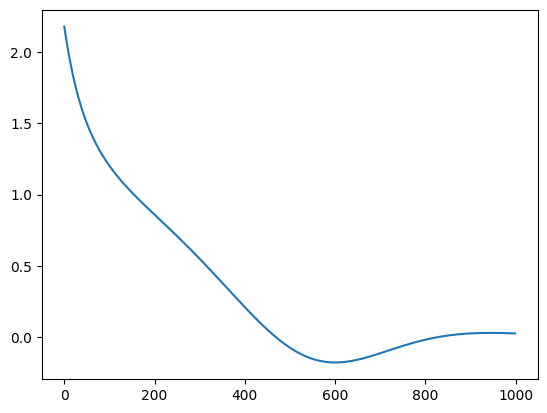

In [295]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

def drift(x):
    return np.array([-x[0] + x[2], 
    x[0]**2 - x[1] - 2*x[0]*x[2] + x[2], 
    -x[1]])

def NCM(x):
    return np.eye(3)

def smooth_relu(x):
    return np.log(1 + np.exp(x))

def multiply_diagonal(W, L_diag, U_diag, side='right'):
    """
    Multiply matrix W with diagonal interval matrix [L_diag, U_diag].
    
    If side = 'right', returns bounds for W * J
    If side = 'left',  returns bounds for J * W
    """
    L_diag = np.asarray(L_diag).reshape(-1)
    U_diag = np.asarray(U_diag).reshape(-1)

    if side == 'right':
        prod1 = W * L_diag  # broadcasting
        prod2 = W * U_diag
    elif side == 'left':
        prod1 = (L_diag[:, None]) * W
        prod2 = (U_diag[:, None]) * W
    else:
        raise ValueError("side must be 'left' or 'right'")

    lower = np.minimum(prod1, prod2)
    upper = np.maximum(prod1, prod2)
    return lower, upper

def multiply_known_W(W, lower, upper, side='right'):
    if side == 'right':
        lower_new = lower @ W
        upper_new = upper @ W
    elif side == 'left':
        lower_new = W @ lower
        upper_new = W @ upper
    else:
        raise ValueError("side must be 'left' or 'right'")
    lower, upper = np.minimum(lower_new, upper_new), np.maximum(lower_new,upper_new)
    return lower- upper

B = np.array([0, 0, 1])

T = 1000
dt = 0.01

xs = np.zeros((3, T))
x = xs[:,0] + 2.2
print(x.size)
for i in range(T):
    x += dt * drift(x)
    xs[:,i] = x

print(xs[:,-1])

plt.plot(xs[2,:])

In [3]:
xlow = np.array([-0.5, -0.5, -0.5])
xhigh = np.array([0.5, 0.5, 0.5])

W1 = np.random.randn(3, 16)
W2 = np.random.randn(16)



In [4]:
W1 = np.array([[1.0, 2.0], [-1.0, 0.5]])
W2 = np.array([[0.5, -1.0], [2.0,  1.0]])
W3 = np.array([[1.0, 0.0], [0.0, 1.0]])

L1 = np.array([0.5, -1.0])
U1 = np.array([1.5,  0.0])

L2 = np.array([-0.5, 0.2])
U2 = np.array([1.0,  1.0])

'''
# TODOs
1. Compute intermediate interval bounds on the z_k
2. Compute the bounds on the J_i, L_i <= J_i <= U_i
3. Compute the bounds then on the product defining Du(x)
'''

def linear_interval(W, l, u):
    W_plus = np.maximum(W, 0)
    W_minus = W - W_plus
    
    lower = W_plus @ l + W_minus @ u
    upper = W_plus @ u + W_minus @ l
    return lower, upper

def get_hidden_preactivation_bounds(x_lower, x_over, W1, W2):
    bounds = []
    l1, u1 = linear_interval(W1, x_lower, x_over)

    l_inter, u_inter = smooth_relu(l1), smooth_relu(u1)
    l2, u2 = linear_interval(W2, l1, u1)
    return l1, u1

def get_diagonal_bounds(l, u):
    return smooth_deriv(l), smooth_deriv(u)



In [314]:
import torch
import torch.nn as nn

class NN_IBP(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[16, 16], output_dim=1, activation='softplus', trainable_NCM=False):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        if trainable_NCM:
            self.P = nn.Linear(input_dim, input_dim, bias = False)
        else:
            self.P = nn.Linear(input_dim, input_dim, bias = False)
            self.P.weight.requires_grad = False

        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(dims[i], dims[i+1]))
            if activation == 'softplus':
                self.activations.append(nn.Softplus())
            elif activation == 'relu':
                self.activations.append(nn.ReLU())
            else:
                raise ValueError(f"Unsupported activation: {activation}")

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def constant_NCM(self):
        return self.P.weight @ torch.transpose(self.P.weight, 0, 1) + torch.eye(self.P.weight.shape[-1])

    def forward(self, x):
        for layer, act in zip(self.hidden_layers, self.activations):
            x = act(layer(x))
        return self.output_layer(x)

    def get_hidden_pre_activation_bounds(self, x_lower, x_upper):
        """
        Compute pre-activation interval bounds for each hidden layer.

        Args:
            x_lower: Tensor of shape (B, input_dim)
            x_upper: Tensor of shape (B, input_dim)

        Returns:
            List of tuples (l_i, u_i): pre-activation bounds at each hidden layer
        """
        def linear_interval(layer: nn.Linear, l, u):
            W = layer.weight
            b = layer.bias
            W_pos = torch.clamp(W, min=0)
            W_neg = torch.clamp(W, max=0)

            lower = torch.matmul(l, W_pos.T) + torch.matmul(u, W_neg.T) + b
            upper = torch.matmul(u, W_pos.T) + torch.matmul(l, W_neg.T) + b
            return lower, upper

        def activation_interval(act, l, u):
            return act(l), act(u)

        bounds = []

        l, u = x_lower, x_upper
        for layer, act in zip(self.hidden_layers, self.activations):
            l_pre, u_pre = linear_interval(layer, l, u)
            bounds.append((l_pre, u_pre))
            l, u = activation_interval(act, l_pre, u_pre)

        return bounds
    
    def activation_derivative(self, x):
        # return 1/(1 + torch.exp(-x))
        #alpha = 0.3
        return torch.sigmoid(x)

    def get_diagonal_bounds_from_intermediate(self, pre_act_bounds):
        diagonal_bounds = []
        for i in range(len(pre_act_bounds)):
            lower_diag_bound = self.activation_derivative(pre_act_bounds[i][0])
            upper_diag_bound = self.activation_derivative(pre_act_bounds[i][1])
            diagonal_bounds.append((lower_diag_bound, upper_diag_bound))
        return diagonal_bounds

    def get_diag_bounds(self, l, u):
        pre_act_bounds = self.get_hidden_pre_activation_bounds(l, u)
        return self.get_diagonal_bounds_from_intermediate(pre_act_bounds)
    
    def left_multiply_by_diag(self, J_lower, J_upper, P_lower, P_upper):
        """
        Batched version: Compute bounds on J @ P, where J is diagonal
        with diag entries in [J_lower, J_upper], and P is an interval matrix.

        Args:
            J_lower, J_upper: (b, n)
            P_lower, P_upper: (b, n, m)

        Returns:
            (lower, upper): (b, n, m)
        """
        # Expand diagonal bounds to match P's shape for broadcasting
        J_lower_exp = J_lower.unsqueeze(-1)  # (b, n, 1)
        J_upper_exp = J_upper.unsqueeze(-1)  # (b, n, 1)

        # Four possible products
        ll = J_lower_exp * P_lower
        lu = J_lower_exp * P_upper
        ul = J_upper_exp * P_lower
        uu = J_upper_exp * P_upper

        # Elementwise min/max over the four cases
        lower = torch.minimum(torch.minimum(ll, lu), torch.minimum(ul, uu))
        upper = torch.maximum(torch.maximum(ll, lu), torch.maximum(ul, uu))

        return lower, upper


    def left_multiply_by_constant_matrix(self, P_lower, P_upper, W):
        """
        Batched version: Compute bounds on W @ P, given bounds on P.

        Args:
            P_lower, P_upper: (b, n, m)
            W: (k, n) constant matrix

        Returns:
            (lower, upper): (b, k, m)
        """
        # Use batch matrix multiply: (b, k, n) @ (b, n, m)
        W_exp = W.unsqueeze(0).expand(P_lower.shape[0], -1, -1)  # (b, k, n)

        X1 = torch.bmm(W_exp, P_lower)
        X2 = torch.bmm(W_exp, P_upper)

        lower = torch.minimum(X1, X2)
        upper = torch.maximum(X1, X2)

        return lower, upper

    def compute_full_product_bound(self, diag_bounds_list, elision_matrix):
        """
        Computes interval bounds on the product:
        W_out · J_N · W_{N-1} · J_{N-1} · ... · J_2 · W_1

        Batched version.

        Args:
            diag_bounds_list: list of (J_lower_i, J_upper_i), each of shape (b, n_i)
                            length = N-1
            elision_matrix: optional matrix to multiply with W_out at the end

        Returns:
            (M_lower, M_upper): tensors of shape (b, k, m) — bounds on the final matrix product
        """
        batch_size = diag_bounds_list[0][0].shape[0]
        assert len(diag_bounds_list) == len(self.hidden_layers), \
            f"Expected {len(self.hidden_layers)} diag bounds but got {len(diag_bounds_list)}"

        # Step 1: Start from the rightmost matrix: W_1
        W1 = self.hidden_layers[0].weight.clone()  # (n1, m1)
        P_lower = W1.unsqueeze(0).expand(batch_size, -1, -1).clone()
        P_upper = W1.unsqueeze(0).expand(batch_size, -1, -1).clone()

        # Step 2: Loop through J_2, W_2, ..., J_N
        for i in range(1, len(self.hidden_layers)):
            # Multiply on the left with diag(J_i)
            J_lower, J_upper = diag_bounds_list[i - 1]  # (b, n_i)
            P_lower, P_upper = self.left_multiply_by_diag(J_lower, J_upper, P_lower, P_upper)

            # Multiply on the left with constant W_i
            W_i = self.hidden_layers[i].weight  # (n_{i+1}, n_i)
            P_lower, P_upper = self.left_multiply_by_constant_matrix(P_lower, P_upper, W_i)

        # Step 3: Final left multiplication with J_N
        J_lower, J_upper = diag_bounds_list[-1]
        P_lower, P_upper = self.left_multiply_by_diag(J_lower, J_upper, P_lower, P_upper)

        # Step 4: Multiply by W_out
        W_out = self.output_layer.weight.clone()  # (k, n_last)
        if elision_matrix is not None:
            W_out = elision_matrix @ W_out
        final_lower, final_upper = self.left_multiply_by_constant_matrix(P_lower, P_upper, W_out)

        return final_lower, final_upper

    
    def compute_Du_bounds(self, l, u, elision_matrix = None):
        diag_bounds = self.get_diag_bounds(l, u)
        return self.compute_full_product_bound(diag_bounds, elision_matrix)
        
    

In [315]:
'''
0. Incorporate elision for constant contraction metric case -- DONE
1. Compute the interval bounds on the given vector field -- DONE
2. Computer upper bound on Metzlerization -- DONE
3. Check spectral abscissa -- DONE
4. ???
4
5. Partitioning
6. Neural contraction metrics
7. Training?
'''

'\n0. Incorporate elision for constant contraction metric case -- DONE\n1. Compute the interval bounds on the given vector field -- DONE\n2. Computer upper bound on Metzlerization -- DONE\n3. Check spectral abscissa -- DONE\n4. ???\n4\n5. Partitioning\n6. Neural contraction metrics\n7. Training?\n'

In [316]:
def f(x):
    # Example from Manchester and Slotine
    return torch.tensor([-x[0] + x[2], 
    x[0]**2 - x[1] - 2*x[0]*x[2] + x[2], 
    -x[1]])

def Df(x):
    """
    Jacobian of vector field for batched input.
    
    Args:
        x: Tensor of shape (batch_size, 3) or (3,)
    Returns:
        Jacobian: Tensor of shape (batch_size, 3, 3)
    """
    # Ensure batch dimension
    if x.ndim == 1:
        x = x.unsqueeze(0)

    batch_size = x.shape[0]
    J = torch.zeros(batch_size, 3, 3, dtype=x.dtype, device=x.device)

    # Fill in the Jacobian
    J[:, 0, 0] = -1
    J[:, 0, 1] = 0
    J[:, 0, 2] = 1

    J[:, 1, 0] = 2*x[:, 0] - 2*x[:, 2]
    J[:, 1, 1] = -1
    J[:, 1, 2] = -2*x[:, 0] + 1

    J[:, 2, 0] = 0
    J[:, 2, 1] = -1
    J[:, 2, 2] = 0

    return J

def jac_bounds_old(l, u):
    lower = torch.tensor([[-1, 0, 1],
                         [2*l[0] - 2*u[2], -1, -2*u[0] + 1],
                         [0, -1, 0]])
    upper = torch.tensor([[-1, 0, 1],
                         [2*u[0] - 2*l[2], -1, -2*l[0] + 1],
                         [0, -1, 0]])
    return lower, upper

def jac_bounds(l, u):
    # l, u: (B, 3) or (3,) if unbatched
    # Ensure batching
    if l.ndim == 1:
        l = l.unsqueeze(0)
        u = u.unsqueeze(0)
    
    B = l.shape[0]
    device = l.device
    dtype = l.dtype
    
    lower = torch.zeros((B, 3, 3), device=device, dtype=dtype)
    upper = torch.zeros((B, 3, 3), device=device, dtype=dtype)
    
    # Fill in constant entries
    lower[:, 0, 0] = -1
    lower[:, 0, 2] = 1
    lower[:, 1, 1] = -1
    lower[:, 2, 1] = -1
    
    upper[:, 0, 0] = -1
    upper[:, 0, 2] = 1
    upper[:, 1, 1] = -1
    upper[:, 2, 1] = -1
    
    # Fill in l/u dependent entries
    lower[:, 1, 0] = 2*l[:, 0] - 2*u[:, 2]
    lower[:, 1, 2] = -2*u[:, 0] + 1
    
    upper[:, 1, 0] = 2*u[:, 0] - 2*l[:, 2]
    upper[:, 1, 2] = -2*l[:, 0] + 1
    
    return (lower, upper)


B = torch.tensor([[0.], [0.], [1.]])


In [317]:
def max_eig_over_hyperrectangles(J_func, l, u, P, num_samples=100):
    """
    Compute the maximum eigenvalue of P @ J(x) + J(x).T @ P
    over random samples inside each hyperrectangle.

    Args:
        J_func: callable, takes (..., dim) tensor and returns (..., n, n) Jacobians.
        bounds: tensor of shape (batch, dim, 2) giving [min, max] for each dim.
        P: (n, n) symmetric matrix.
        num_samples: number of samples per hyperrectangle.

    Returns:
        max_eigs: tensor of shape (batch,) with max eigenvalue per hyperrectangle.
    """
    batch_size, dim = l.shape
    device = l.device
    n = P.shape[0]

    # Sample uniformly in each hyperrectangle
    rand = torch.rand(batch_size, num_samples, dim, device=device)
    samples = l[:, None, :] + rand * (u - l)[:, None, :]  # (batch, num_samples, dim)

    # Flatten samples for batch processing
    flat_samples = samples.reshape(-1, dim)  # (batch * num_samples, dim)

    # Evaluate J(x) for all samples
    J_vals = J_func(flat_samples)  # (batch*num_samples, n, n)

    # Compute PJ + J^T P
    PJ = torch.matmul(P, J_vals)  # (batch*num_samples, n, n)
    JTP = torch.matmul(J_vals.transpose(-1, -2), P)
    M = PJ + JTP  # (batch*num_samples, n, n)

    # Compute largest eigenvalue for each matrix
    eigvals = torch.linalg.eigvalsh(M)  # (..., n)
    max_eigs_per_sample = eigvals[..., -1]  # (batch*num_samples,)

    # Reshape back to (batch, num_samples) and take max over samples
    max_eigs = max_eigs_per_sample.view(batch_size, num_samples).max(dim=1).values

    return max_eigs

P = torch.eye(3)
print(max_eig_over_hyperrectangles(Df, xunder, xover, P))

tensor([18.9915, 19.7152, 20.9924, 23.6692, 25.6937, 28.6966, 31.4117, 35.0204,
        37.6233, 41.8136, 18.9816, 19.8745, 21.2642, 23.2586, 25.9117, 28.9380,
        31.5721, 35.3096, 38.2805, 42.0662, 19.1473, 19.8348, 21.1677, 23.3665,
        25.7702, 28.9480, 31.9658, 34.9776, 38.9365, 42.2103, 19.0894, 19.7076,
        21.4408, 23.2042, 25.8694, 28.8064, 31.4964, 35.0458, 37.8131, 41.7284,
        19.0152, 19.8420, 21.4039, 23.2124, 26.1238, 28.9319, 31.6131, 35.3241,
        38.7636, 41.9893, 18.9703, 19.8283, 21.3206, 23.1217, 26.1183, 28.6994,
        32.0397, 35.0341, 38.4560, 41.6195, 18.9438, 19.8096, 21.0024, 23.3271,
        25.5576, 28.8191, 31.8567, 35.2829, 38.5295, 41.7398, 19.2180, 19.9440,
        21.5484, 23.0543, 25.9967, 28.5112, 31.4755, 34.4025, 38.4819, 42.1693,
        18.9859, 19.9325, 21.1713, 23.1720, 25.8085, 28.7514, 31.7863, 35.1947,
        38.6921, 41.9988, 19.1669, 19.8392, 21.4781, 23.0110, 25.8557, 28.9258,
        31.0251, 35.4509, 38.0618, 41.86

In [318]:
def compute_metzler_upper_bound(jac_bounds, controller_bounds):
    jac_lower, jac_upper = jac_bounds       # (B, n, n)
    Du_lower, Du_upper = controller_bounds  # (B, n, n)
    
    # Transpose only the last two dims for batching
    jac_lower_T = jac_lower.transpose(-1, -2)
    jac_upper_T = jac_upper.transpose(-1, -2)
    Du_lower_T = Du_lower.transpose(-1, -2)
    Du_upper_T = Du_upper.transpose(-1, -2)
    
    # Compute LMI lower and upper bounds (batch-wise)
    lmi_lower = 0.5 * (jac_lower + jac_lower_T + Du_lower + Du_lower_T)
    lmi_upper = 0.5 * (jac_upper + jac_upper_T + Du_upper + Du_upper_T)
    
    # Elementwise maximum for the Metzler bound
    mat_abs = torch.maximum(lmi_upper, -lmi_lower)
    
    # Extract diagonals in batched way
    diag_mat_abs = torch.diagonal(mat_abs, dim1=-2, dim2=-1)
    diag_lmi_upper = torch.diagonal(lmi_upper, dim1=-2, dim2=-1)
    
    # Zero out diagonal of mat_abs, then replace with lmi_upper diagonal
    result = mat_abs - torch.diag_embed(diag_mat_abs) + torch.diag_embed(diag_lmi_upper)
    
    return result

def compute_metzler_upper_bound_new(jac_eigenbounds, controller_bounds):
    #jac_lower, jac_upper = jac_bounds       # (B, n, n)
    Du_lower, Du_upper = controller_bounds  # (B, n, n)
    
    # Transpose only the last two dims for batching
    #jac_lower_T = jac_lower.transpose(-1, -2)
    #jac_upper_T = jac_upper.transpose(-1, -2)
    Du_lower_T = Du_lower.transpose(-1, -2)
    Du_upper_T = Du_upper.transpose(-1, -2)
    
    # Compute LMI lower and upper bounds (batch-wise)
    lmi_lower = (Du_lower + Du_lower_T)
    lmi_upper = (Du_upper + Du_upper_T)
    
    # Elementwise maximum for the Metzler bound
    mat_abs = torch.maximum(lmi_upper, -lmi_lower)
    
    # Extract diagonals in batched way
    diag_mat_abs = torch.diagonal(mat_abs, dim1=-2, dim2=-1)
    diag_lmi_upper = torch.diagonal(lmi_upper, dim1=-2, dim2=-1)
    
    # Zero out diagonal of mat_abs, then replace with lmi_upper diagonal
    result = mat_abs - torch.diag_embed(diag_mat_abs) + torch.diag_embed(diag_lmi_upper) + jac_eigenbounds[:, None, None] * torch.eye(Du_upper.shape[-1])
    print(result[0])
    return result


def max_eig_metzler(M, num_iter=200, tol=1e-8):
    """
    Compute max eigenvalue of batched Metzler matrices M using power iteration.

    Args:
        M: (b, n, n) batched Metzler matrices
        num_iter: max iterations
        tol: convergence tolerance

    Returns:
        lambda_max: (b,) largest eigenvalues per batch
    """
    bshape = M.shape[:-2]
    n = M.shape[-1]
    v = torch.ones(*bshape, n, dtype=M.dtype, device=M.device)
    v = v / v.sum(dim=-1, keepdim=True)

    for _ in range(num_iter):
        v_next = torch.matmul(M, v.unsqueeze(-1)).squeeze(-1)
        norm = v_next.sum(dim=-1, keepdim=True)
        v_next = v_next / (norm + 1e-12)
        v_next = torch.clamp(v_next, min=1e-8)
        
        # Convergence check (L1 difference)
        if torch.max(torch.abs(v_next - v)) < tol:
            break
        v = v_next

    # Rayleigh quotient estimate
    numerator = torch.sum(v * torch.matmul(M, v.unsqueeze(-1)).squeeze(-1), dim=-1)
    denominator = torch.sum(v * v, dim=-1)
    lambda_max = numerator / (denominator + 1e-12)
    return lambda_max

def smooth_relu(x, delta=1.0):
    # x: tensor
    # delta: smoothing interval width > 0

    zero = torch.zeros_like(x)
    # mask regions
    mask_neg = (x <= 0)
    mask_smooth = (x > 0) & (x < delta)
    mask_linear = (x >= delta)

    a = -2.0 / (delta ** 3)
    b = 3.0 / (delta ** 2)

    # Compute smooth cubic part
    smooth_part = a * x**3 + b * x**2

    return torch.where(
        mask_neg, zero,
        torch.where(
            mask_smooth, smooth_part,
            x  # linear region
        )
    )

def max_eig_metzler_shifted(M, num_iter=50, tol=1e-4):
    """
    Compute the max eigenvalue of a batched symmetric Metzler matrix M using power iteration,
    with spectral shift to ensure nonnegativity for stable convergence.

    Args:
        M: (b, n, n) batched symmetric Metzler matrices
        num_iter: maximum power iteration steps
        tol: convergence tolerance

    Returns:
        lambda_max: (b,) largest eigenvalue estimates per batch
    """
    bshape = M.shape[:-2]
    n = M.shape[-1]
    device = M.device
    dtype = M.dtype

    # Compute the shift scalar: at least -min diagonal entry, plus small margin
    # Since M is Metzler, off-diagonal >= 0 but diagonals can be negative
    min_diag, _ = torch.min(torch.diagonal(M, dim1=-2, dim2=-1), dim=-1, keepdim=True)  # (b,1)
    shift = -min_diag + 1e-3  # small positive margin
    shift = shift.unsqueeze(-1)  # shape (b,1,1) for broadcasting

    # Shift the matrix: M_shifted = M + shift * I
    I = torch.eye(n, device=device, dtype=dtype).unsqueeze(0).expand(*bshape, n, n)
    M_shifted = M + shift * I

    # Initialize positive starting vector (batch)
    v = torch.ones(*bshape, n, device=device, dtype=dtype)
    v = v / v.sum(dim=-1, keepdim=True)

    for _ in range(num_iter):
        v_next = torch.matmul(M_shifted, v.unsqueeze(-1)).squeeze(-1)
        norm = v_next.sum(dim=-1, keepdim=True)
        v_next = v_next / (norm + 1e-12)
        v_next = torch.clamp(v_next, min=1e-8)
        
        if torch.max(torch.abs(v_next - v)) < tol:
            break
        v = v_next

    # Rayleigh quotient for shifted matrix
    numerator = torch.sum(v * torch.matmul(M_shifted, v.unsqueeze(-1)).squeeze(-1), dim=-1)
    denominator = torch.sum(v * v, dim=-1)
    lambda_max_shifted = numerator / (denominator + 1e-12)

    # Subtract shift to get original max eigenvalue
    lambda_max = lambda_max_shifted - shift.squeeze(-1).squeeze(-1)

    return lambda_max

def partition_hyperrectangle(xunder, xover, n_parts):
    """
    Partition a hyperrectangle [xunder, xover] into n_parts equally sized sub-rectangles.

    Args:
        xunder (torch.Tensor): Lower corner, shape (d,)
        xover (torch.Tensor): Upper corner, shape (d,)
        n_parts (int): Number of partitions (must be a^d for some integer a)

    Returns:
        sub_xunder (torch.Tensor): Lower corners of sub-rectangles, shape (n_parts, d)
        sub_xover (torch.Tensor): Upper corners of sub-rectangles, shape (n_parts, d)
    """
    dim = xunder.shape[0]
    # Determine number of splits along each axis
    splits_per_dim = round(n_parts ** (1.0 / dim))
    assert splits_per_dim ** dim == n_parts, \
        "n_parts must be a perfect power of the number of dimensions"

    # Create equally spaced points along each dimension
    edges = [
        torch.linspace(xunder[i], xover[i], splits_per_dim + 1)
        for i in range(dim)
    ]

    # Lower and upper bounds for each small rectangle
    lower_grid = torch.stack(torch.meshgrid(*[e[:-1] for e in edges], indexing='ij'), dim=-1)
    upper_grid = torch.stack(torch.meshgrid(*[e[1:] for e in edges], indexing='ij'), dim=-1)

    sub_xunder = lower_grid.reshape(-1, dim)
    sub_xover = upper_grid.reshape(-1, dim)

    return sub_xunder, sub_xover


# Example usage:
xunder = torch.tensor([0.0, 0.0, 0.0])
xover = torch.tensor([1.0, 2.0, 3.0])
n_parts = 64  # 4^3

sub_xunder, sub_xover = partition_hyperrectangle(xunder, xover, n_parts)

print(sub_xunder.shape)  # (64, 3)
print(sub_xover.shape)   # (64, 3)


model = NN_IBP()
print(model)

xunder = -0.5*torch.ones(3)
xover = -xunder

diag_bounds = model.get_diag_bounds(xunder, xover)
#print(diag_bounds)

Du_lower, Du_upper = model.compute_Du_bounds(xunder, xover, elision_matrix=B)
jac_lower, jac_upper = jac_bounds(xunder, xover)

'''
Want bound on P @ Df + Df^T P + P B Du + (P B Du)^T
'''



torch.Size([64, 3])
torch.Size([64, 3])
NN_IBP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (activations): ModuleList(
    (0-1): 2 x Softplus(beta=1.0, threshold=20.0)
  )
  (P): Linear(in_features=3, out_features=3, bias=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)


'\nWant bound on P @ Df + Df^T P + P B Du + (P B Du)^T\n'

In [ ]:
import torch.optim as optim

# --- Hyperparameters ---
eps = 1e-8
learning_rate = 1e-2
num_epochs = 20000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xunder = -10*torch.ones(3)
eye = torch.eye(3).to(device=device)
xover = 10*torch.ones(3)

xunder, xover = partition_hyperrectangle(xunder, xover, 10**3)

# --- Send model to device ---
model = NN_IBP(hidden_dims=[32,32], trainable_NCM=True)
model = model.to(device)

# --- Loss and optimizer ---
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Training loop ---
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    # Check this function for bugs
    NCM = model.constant_NCM()
    Du_bounds = model.compute_Du_bounds(xunder, xover, elision_matrix=NCM @ B)

    #print(Du_bounds[0].shape)
    Df_lower, Df_upper = jac_bounds(xunder, xover)
    Df_lower, Df_upper = model.left_multiply_by_constant_matrix(Df_lower, Df_upper, NCM)
    #print(Df_bounds[0].shape)
    # eigenbounds = max_eig_over_hyperrectangles(Df, xunder, xover, NCM)
    B_Mzr = compute_metzler_upper_bound((Df_lower, Df_upper), Du_bounds)
    # B_Mzr = compute_metzler_upper_bound_new(eigenbounds, Du_bounds)
    # improve conditioning
    B_Mzr = B_Mzr + eps * torch.eye(B_Mzr.shape[-1], device=B_Mzr.device).unsqueeze(0)
    try:
        eigs = torch.linalg.eigvalsh(B_Mzr)
    except:
        print('poor conditioning')
        print(B_Mzr[0])
        
        break
    max_eig = eigs.amax(dim=tuple(range(1, eigs.ndim)))
    # max_eig = max_eig_metzler_shifted(B_Mzr)
    # max_eig = B_Mzr.sum(dim=-1)
    # print(max_eig)
    loss = torch.sum(torch.relu(max_eig))
    if torch.isnan(loss):
        print('NaN detected in loss')
        break

    if loss <= 1e-7:
        print('At epoch ', epoch+1, ' loss has hit 0, valid closed-loop contracting controller')
        print('Metzler upper bound:', B_Mzr[0])
        print(torch.linalg.eigvalsh(B_Mzr))
        break

    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"NaN detected in gradients of {name}")

    if epoch % 1000 == 999:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {loss:.4f} ")
        

print('contraction metric', model.constant_NCM())

Epoch [1000/20000] Loss: 445.1563 
Epoch [2000/20000] Loss: 121.8278 
Epoch [3000/20000] Loss: 43.8706 
Epoch [4000/20000] Loss: 16.3270 
Epoch [5000/20000] Loss: 4.5310 
Epoch [6000/20000] Loss: 2.4599 
Epoch [7000/20000] Loss: 0.0079 
At epoch  7009  loss has hit 0, valid closed-loop contracting controller
Metzler upper bound: tensor([[-4.1995e+02,  2.6099e+00,  1.4792e+01],
        [ 2.6099e+00, -1.0168e+00,  5.5970e+00],
        [ 1.4792e+01,  5.5970e+00, -1.3082e+03]], grad_fn=<SelectBackward0>)
tensor([[-1.3084e+03, -4.1972e+02, -9.7579e-01],
        [-1.3083e+03, -4.1976e+02, -9.4093e-01],
        [-1.3064e+03, -4.1988e+02, -8.8992e-01],
        ...,
        [-1.6836e+03, -4.2197e+02, -8.2219e-01],
        [-1.6775e+03, -4.2196e+02, -8.5921e-01],
        [-1.6759e+03, -4.2193e+02, -8.7068e-01]],
       grad_fn=<LinalgEighBackward0>)
contraction metric tensor([[ 4.0063e+02, -4.9076e-03,  5.1186e-01],
        [-4.9076e-03,  1.0001e+00,  1.9810e-02],
        [ 5.1186e-01,  1.9810e-

In [324]:
xunder = -10.0*torch.ones(3)
xover = 10.0*torch.ones(3)

NCM = model.constant_NCM()

xunder, xover = partition_hyperrectangle(xunder, xover, 10**3)

Du_bounds = model.compute_Du_bounds(xunder, xover, elision_matrix=NCM @ B)
Df_lower, Df_upper = jac_bounds(xunder, xover)
Df_lower, Df_upper = model.left_multiply_by_constant_matrix(Df_lower, Df_upper, NCM)
B_Mzr = compute_metzler_upper_bound((Df_lower, Df_upper), Du_bounds)


B_Mzr = compute_metzler_upper_bound((Df_lower, Df_upper), Du_bounds)
loss = (torch.max(torch.linalg.eigvalsh(B_Mzr)))

print(loss)

tensor(-9.3708e-05, grad_fn=<MaxBackward1>)


In [ ]:
# Todo:
# 1. Make code modular / file for NN class + file for functions + file for training + file for dynamics
# 1. Get 1 nice example working (pendulum maybe)
# 2. Write code for general contraction metrics M(x) - perhaps another class for NCM